# Regressão logística com Python

Para esta aula, estaremos trabalhando com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning!

Vamos tentar montar um algoritmo de classificação sobrevivente ou falecido utilizando regressão logística no Python.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Os dados

Vamos começar lendo o arquivo titanic_train.csv em um DataFrame pandas.

In [2]:
pwd

'C:\\Users\\alcir\\Analises'

In [48]:
heart = pd.read_csv('heart.csv')

In [5]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Análise de dados exploratórios

Vamos começar algumas análises de dados exploratórios. Começaremos por verificar os dados que faltam!

## Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados!

<AxesSubplot:>

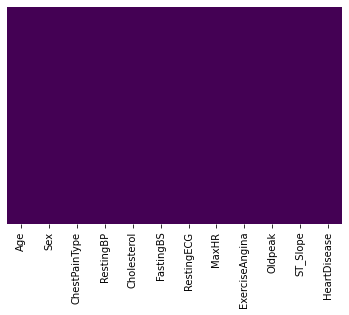

In [6]:
sns.heatmap(heart.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Aproximadamente 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar isso mais tarde ou mudá-lo para outro "Cabin Conhecido: 1 ou 0"

Continuemos visualizando mais alguns dos dados! Confira o vídeo para obter explicações completas sobre esses gráficos, este código é apenas para servir como referência.

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

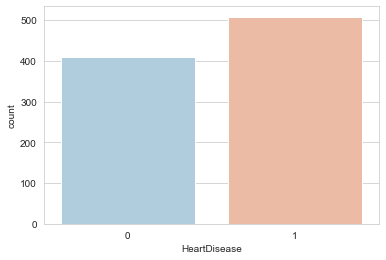

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='HeartDisease',data=heart,palette='RdBu_r')

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

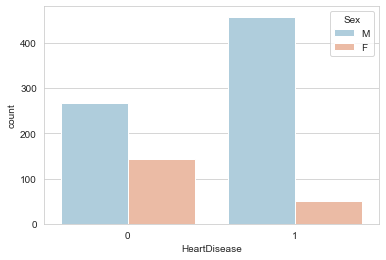

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='HeartDisease',hue='Sex',data=heart,palette='RdBu_r')

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

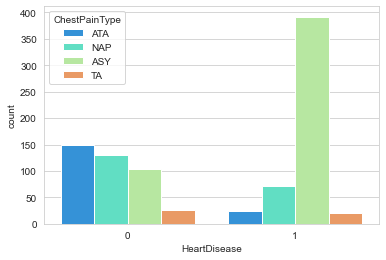

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='HeartDisease',hue='ChestPainType',data=heart,palette='rainbow')

<AxesSubplot:>

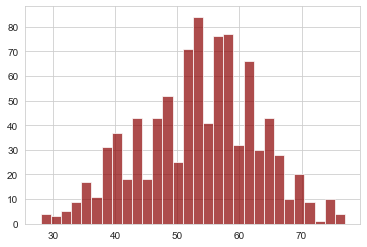

In [13]:
heart['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='Age'>

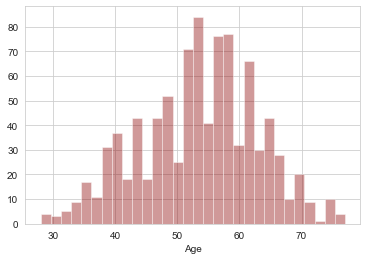

In [16]:
sns.distplot(heart['Age'].dropna(),kde=False,color='darkred',bins=30)

<AxesSubplot:xlabel='RestingECG', ylabel='count'>

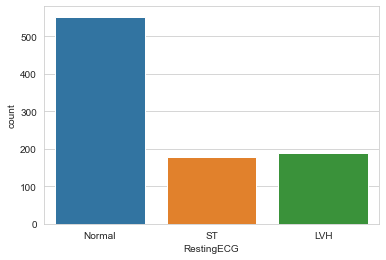

In [17]:
sns.countplot(x='RestingECG',data=heart)

<AxesSubplot:>

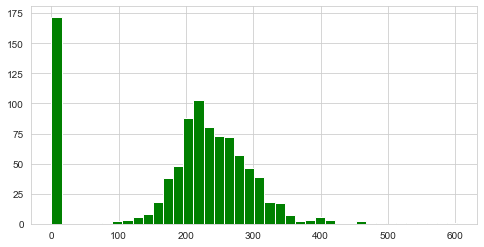

In [18]:
heart['Cholesterol'].hist(color='green',bins=40,figsize=(8,4))

___
## Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Por exemplo:


<AxesSubplot:xlabel='ChestPainType', ylabel='Age'>

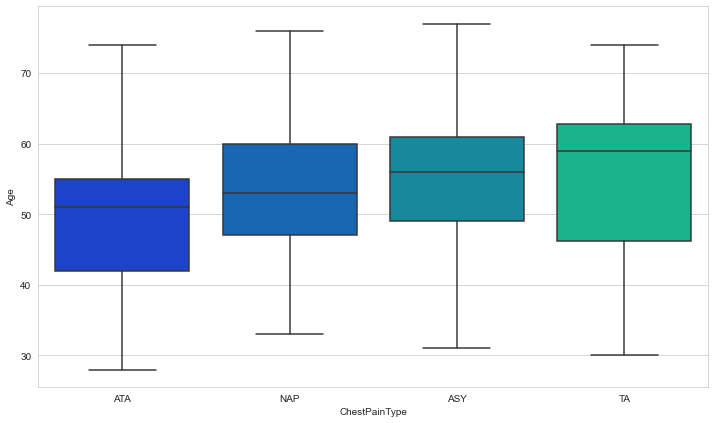

In [23]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='ChestPainType',y='Age',data=heart,palette='winter')

Podemos ver os passageiros mais ricos nas (que estão nas classes superiores) tendem a ser mais velhos, o que faz sentido. Usaremos esses valores de idade média para imputar com base em Pclass for Age.

In [25]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Agora aplique essa função!

In [27]:
heart['Age'] = heart[['Age','HeartDisease']].apply(impute_age,axis=1)

Agora vamos verificar esse mapa de calor novamente!

<AxesSubplot:>

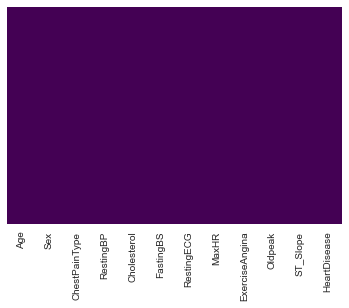

In [28]:
sns.heatmap(heart.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Ótimo! Vamos seguir em frente e deletar a coluna Cabin e a linha em Embarked que falta dado.

In [17]:
train.drop('Cabin',axis=1,inplace=True)

In [91]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [92]:
train.dropna(inplace=True)

## Convertendo recursos categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [30]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [19]:
sex = pd.get_dummies(train['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinaridade
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [71]:
dados = heart.drop(['RestingECG', 'ExerciseAngina','ST_Slope', 'ChestPainType'],axis=1)

In [62]:
dados

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,M,140,289,0,172,0.0,0
1,49,F,160,180,0,156,1.0,1
2,37,M,130,283,0,98,0.0,0
3,48,F,138,214,0,108,1.5,1
4,54,M,150,195,0,122,0.0,0
...,...,...,...,...,...,...,...,...
913,45,M,110,264,0,132,1.2,1
914,68,M,144,193,1,141,3.4,1
915,57,M,130,131,0,115,1.2,1
916,57,F,130,236,0,174,0.0,1


In [63]:
dados.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,40,M,140,289,0,172,0.0,0
1,49,F,160,180,0,156,1.0,1
2,37,M,130,283,0,98,0.0,0
3,48,F,138,214,0,108,1.5,1
4,54,M,150,195,0,122,0.0,0


Ótimo! Nossos dados estão prontos para o nosso modelo

# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

## Divisão treino-teste

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(dados.drop('HeartDisease',axis=1), 
                                                    dados['HeartDisease'], test_size=0.30, 
                                                    random_state=101)

In [74]:
X_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
333,40,95,0,1,144,0.0
291,47,140,257,0,135,1.0
860,60,130,253,0,144,1.4
381,50,115,0,0,120,0.5
268,54,130,242,0,91,1.0
...,...,...,...,...,...,...
575,56,137,282,1,126,1.2
838,63,130,330,1,132,1.8
337,63,150,0,1,154,3.7
523,59,124,160,0,117,1.0


In [75]:
y_test

417    0
325    1
267    0
241    1
367    1
      ..
196    0
83     0
258    0
290    0
407    1
Name: HeartDisease, Length: 276, dtype: int64

## Training and Predicting

In [84]:
from sklearn.linear_model import LogisticRegression

In [114]:
logmodel = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [115]:
predictions = logmodel.predict(X_test)

Vamos seguir em frente para avaliar o nosso modelo!

## Avaliação

Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [116]:
from sklearn.metrics import classification_report

In [117]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       126
           1       0.76      0.78      0.77       150

    accuracy                           0.75       276
   macro avg       0.74      0.74      0.74       276
weighted avg       0.75      0.75      0.75       276

